In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from zipfile import ZipFile

# Import label encoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

from tensorflow.keras.models import Model




In [ ]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [ ]:
# import and read images 

img_array = np.load('/content/grive/MyDrive/images.npy', allow_pickle=True)
type(img_array)

numpy.ndarray

In [ ]:
print(img_array)

[[array([[[42, 37, 34],
          [56, 51, 48],
          [71, 66, 63],
          ...,
          [23, 33, 34],
          [26, 36, 37],
          [28, 38, 39]],

         [[40, 35, 32],
          [51, 46, 43],
          [64, 59, 56],
          ...,
          [27, 36, 35],
          [24, 33, 32],
          [26, 35, 34]],

         [[43, 38, 35],
          [51, 46, 43],
          [61, 56, 53],
          ...,
          [28, 30, 27],
          [33, 35, 32],
          [35, 37, 34]],

         ...,

         [[56, 47, 40],
          [57, 48, 41],
          [61, 52, 45],
          ...,
          [67, 48, 42],
          [55, 35, 28],
          [60, 40, 33]],

         [[53, 44, 37],
          [54, 45, 38],
          [57, 48, 41],
          ...,
          [59, 40, 34],
          [60, 40, 33],
          [54, 34, 27]],

         [[53, 44, 37],
          [54, 45, 38],
          [57, 48, 41],
          ...,
          [59, 40, 34],
          [70, 50, 43],
          [64, 44, 37]]], dtype=uint8)
  list

In [ ]:
'''from matplotlib import pyplot as plt

plt.imshow(img_array, cmap='gray')
plt.show()'''

"from matplotlib import pyplot as plt\n\nplt.imshow(img_array, cmap='gray')\nplt.show()"

In [ ]:
# Image Dataset Shape

images = img_array[:,0]
mask = img_array[:,1]
print(images.shape, mask.shape)

(409,) (409,)


In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
ALPHA = 1

In [ ]:
img_array.shape[0]

409

In [ ]:
# X and y split of data and shape unified

y_masks = np.zeros((int(img_array.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_data = np.zeros((int(img_array.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(img_array.shape[0]):
    img = img_array[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_data[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in img_array[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        y_masks[index][y1:y2, x1:x2] = 1
X_data.shape

(409, 224, 224, 3)

In [ ]:
y_masks.shape

(409, 224, 224)

In [ ]:
# Splitting X and y data into train and test

X_train = X_data[0:400]

In [ ]:
X_test = X_data[400:409]

In [ ]:
X_test.shape

(9, 224, 224, 3)

In [ ]:
X_train.shape

(400, 224, 224, 3)

In [ ]:
y_train_masks = y_masks[0:400]
y_test_masks = y_masks[400:409]

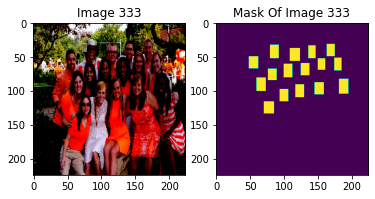

In [ ]:
# Select random image from train data and display its original and masked image

n = 333
pyplot.subplot(1,2,1)
pyplot.title('Image 333')
pyplot.imshow(X_train[n])

pyplot.subplot(1,2,2)
pyplot.title('Mask Of Image 333')
pyplot.imshow(y_train_masks[n])

In [ ]:
# Designing a face mask detection model

model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [ ]:
# Model Creation : Combining pre-trained non-trainable layers of MobileNet with corresponding Upsampling layers to imitate UNET

def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 

In [ ]:
# Display model summary

smodel = create_model()

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

In [ ]:
# Creating customised Dice Coefficient and Loss function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer = optimizer, metrics=[dice_coefficient])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# model checkpoint callback saving the weights of the model along with the structure when there is no decrease in loss
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)

# If Loss does not decrease over 5 epochs, training would stop
stop = EarlyStopping(monitor="loss", patience=5, mode="min")

# If Loss does not decrease over 1 epoch, learning rate would reduce by 20%
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
# Fit model on train dataset

model.fit(X_train,y_train_masks,epochs = 10,verbose=1,batch_size=3,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/10

Epoch 1: loss improved from inf to 3.61466, saving model to model-3.61.h5
  1/134 [..............................] - ETA: 21:30 - loss: 3.6147 - dice_coefficient: 0.0753
Epoch 1: loss improved from 3.61466 to 3.04338, saving model to model-3.04.h5
  2/134 [..............................] - ETA: 31s - loss: 3.0434 - dice_coefficient: 0.1572  
Epoch 1: loss improved from 3.04338 to 2.97066, saving model to model-2.97.h5
  3/134 [..............................] - ETA: 31s - loss: 2.9707 - dice_coefficient: 0.1545
Epoch 1: loss did not improve from 2.97066
  4/134 [..............................] - ETA: 25s - loss: 3.0288 - dice_coefficient: 0.1446
Epoch 1: loss improved from 2.97066 to 2.91453, saving model to model-2.91.h5
  5/134 [>.............................] - ETA: 26s - loss: 2.9145 - dice_coefficient: 0.1498
Epoch 1: loss improved from 2.91453 to 2.76574, saving model to model-2.77.h5
  6/134 [>.............................] - ETA: 27s - loss: 2.7657 - dice_coefficient

Evaluation of the model performance
------------------------------------

A dice coefficient of about 62.33 % obtained which means the dice loss is low as 37.67 % with just 10 epochs. 

In [ ]:
# Predict on a test image at index 3

sample_image = X_test[3]
print(sample_image)

[[[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.06666672  0.1686275 ]
  [ 0.07450986  0.22352946  0.33333337]]

 [[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.05882359  0.1686275 ]
  [ 0.07450986  0.22352946  0.33333337]]

 [[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.05882359  0.1686275 ]
  [ 0.07450986  0.22352946  0.33333337]]

 ...

 [[ 0.68627453  0.53725493  0.4666667 ]
  [ 0.60000002  0.47450984  0.37254906]
  [ 0.72549021  0.58431375  0.48235297]
  ...
  [ 0.33333337  0.32549024  0.29411769]
  [ 0.3176471   0.29411769  0.3176471 ]
  [ 0.37254906  0.36470592  0.34901965]]

 [

In [ ]:
sample_image.shape

(224, 224, 3)

1/1 [==============================] - 0s 402ms/step


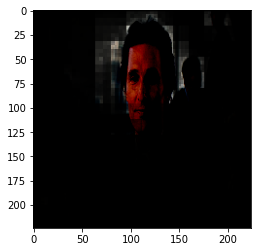

In [ ]:
# Trained Model Predicting Masked Image from a sample image

pred_mask = model.predict(x=np.array([sample_image]))
out_image = sample_image
out_image[:,:,0] = pred_mask*sample_image[:,:,0]
out_image[:,:,1] = pred_mask*sample_image[:,:,1]
out_image[:,:,2] = pred_mask*sample_image[:,:,2]

#out_image = image

pyplot.imshow(out_image)